# ПОИСК АНОМАЛИЙ В ДАННЫХ
## Wine Quality Data Set : https://archive.ics.uci.edu/ml/datasets/Wine+Quality
### _Abstract: Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests_

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_file_name = 'winequality-white.csv'
full_data_frame = pd.read_csv(data_file_name, sep=';')

In [3]:
full_data_frame.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [4]:
full_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


## 1. Корреляция параметров

In [5]:
corr_matrix = full_data_frame.corr()

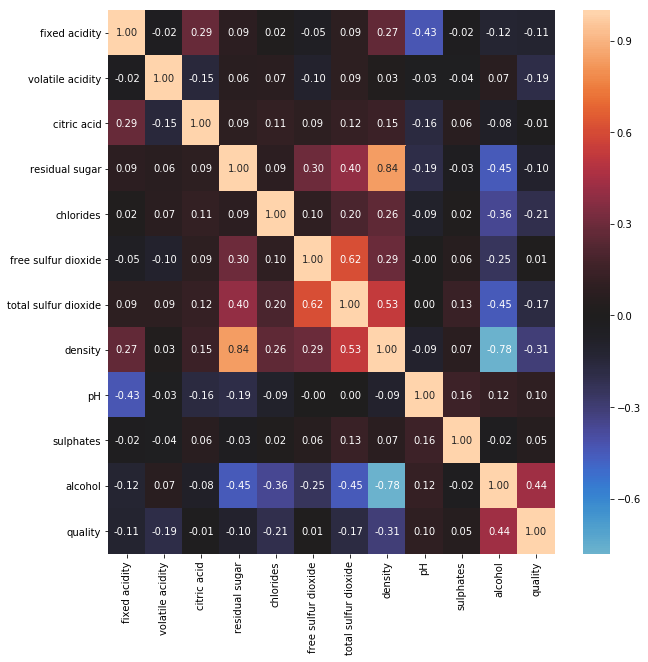

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', center = 0)

In [7]:
data_header=full_data_frame.columns.to_list()
data_header

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [8]:
abnormally_correlated_variables = ['density', 'residual sugar', 'alcohol']
normally_correlated_variables = ['fixed acidity', 'volatile acidity', 'citric acid',
                                 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
                                 'pH', 'sulphates']
numerical_parameters = abnormally_correlated_variables.copy()
numerical_parameters.extend(normally_correlated_variables)

### Есть 3 параметра со значительной корреляцией. Визульно, на попарных зависимостях наблюдается небольшое число выбросов.

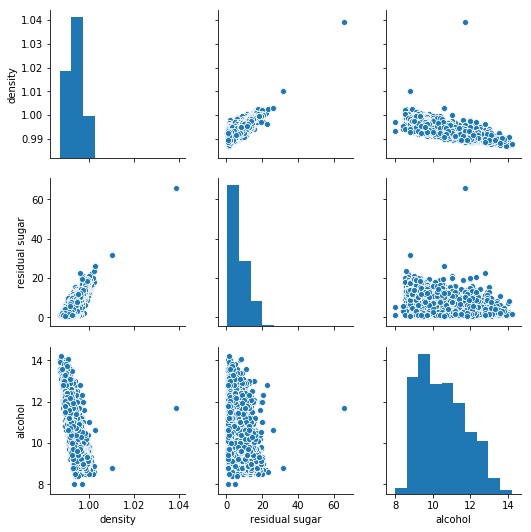

In [9]:
sns.pairplot(full_data_frame[abnormally_correlated_variables])

### На попарных зависимостях остальных параметров выбросов наблюдается больше.

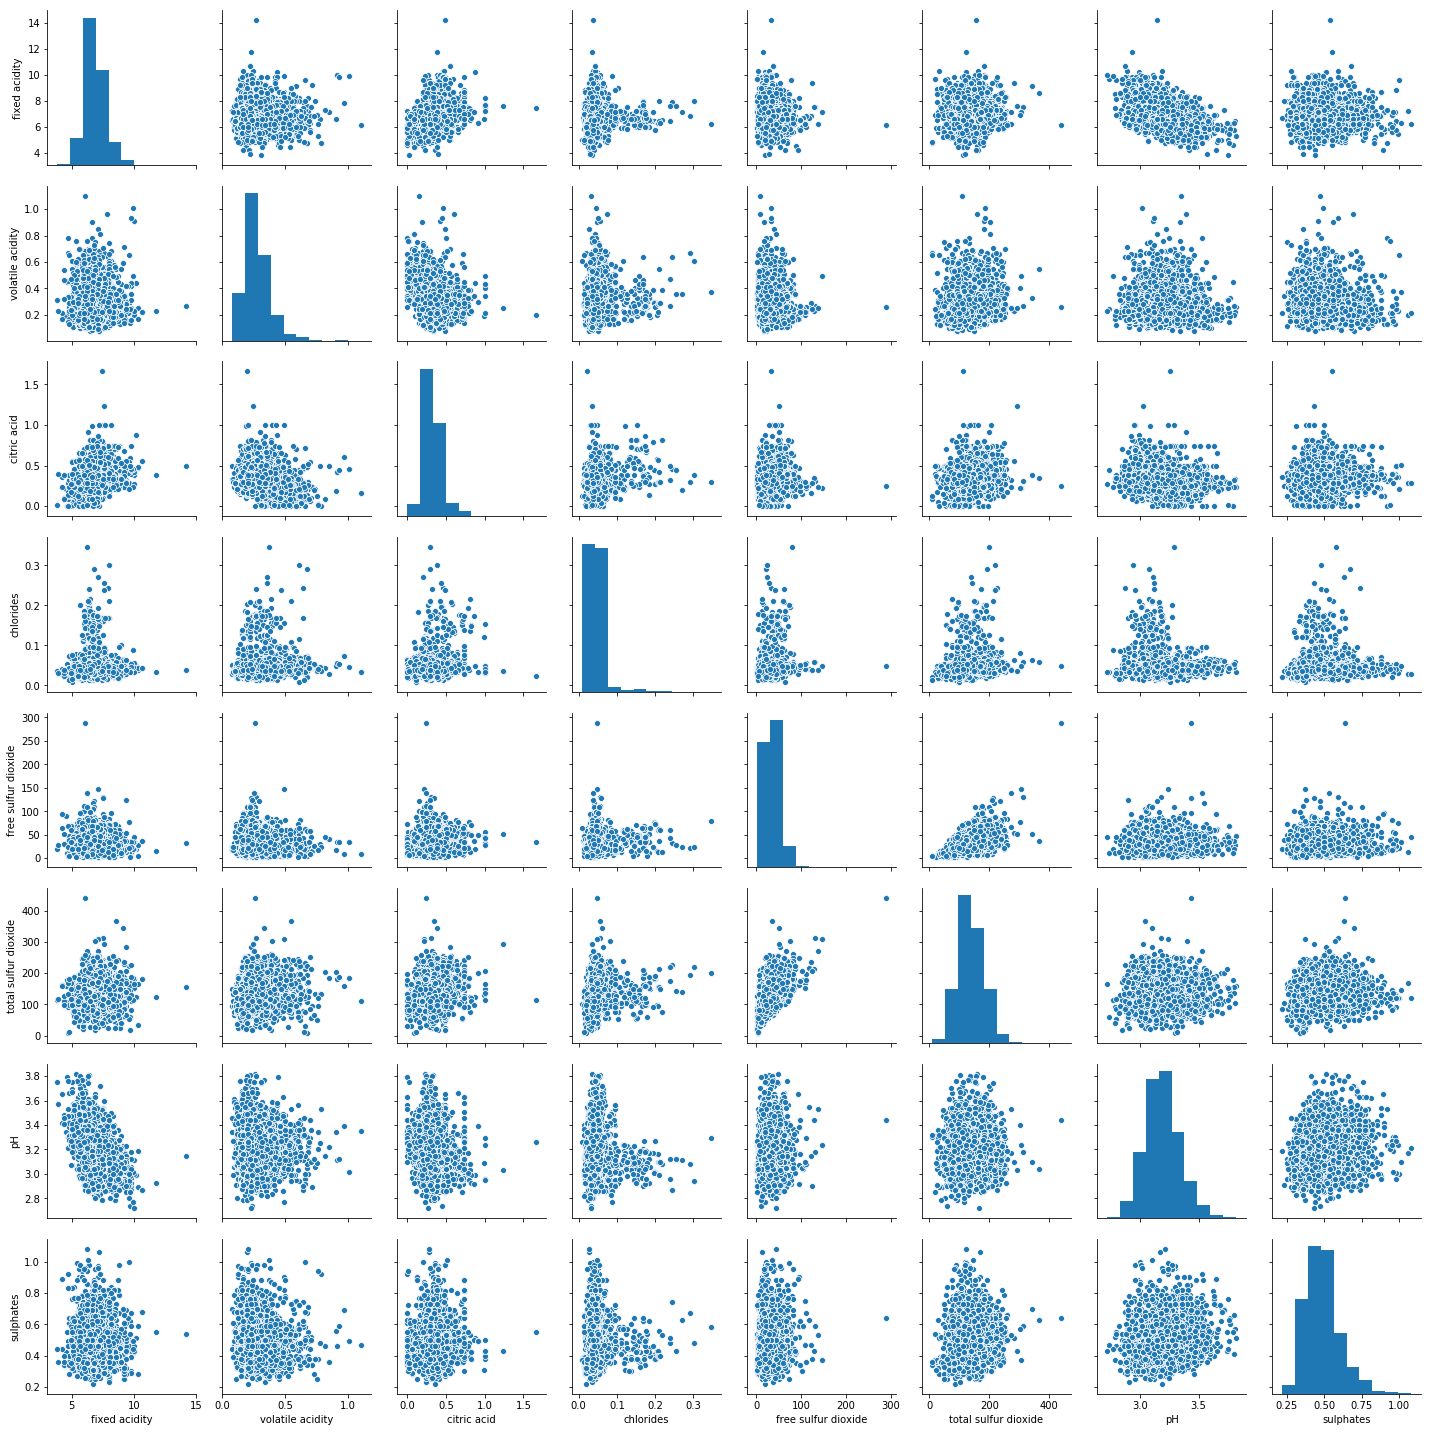

In [10]:
sns.pairplot(full_data_frame[normally_correlated_variables])

### Распределение содержания лимонной кислоты (citric acid) имеет аномальные пики на значениях 0.49 и 0.74.

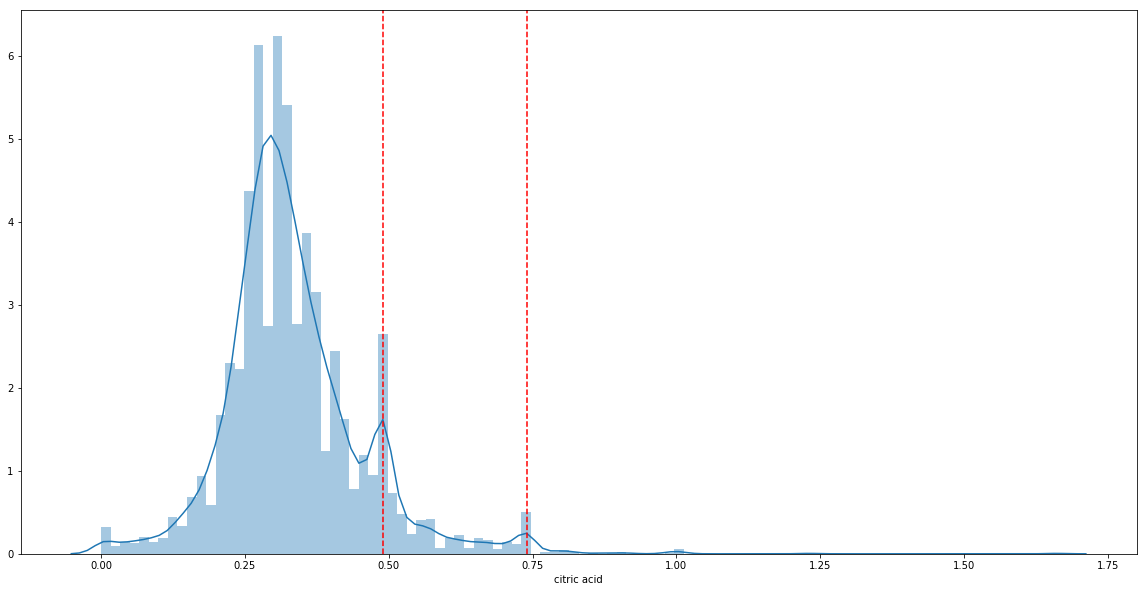

In [11]:
plt.figure(figsize=(20,10))
ax = sns.distplot(full_data_frame['citric acid'], bins=100)
ax.axvline(x=0.49, color='red', linestyle="--")
ax.axvline(x=0.74, color='red', linestyle="--")

## 2. Поиск анамалий по базовым статистикам

## Отклонение от среднего на величину, большую $3\sigma$

In [12]:
def outlier_detect_mean_std(data,col,threshold=3):
    Upper_fence = data[col].mean() + threshold * data[col].std()
    Lower_fence = data[col].mean() - threshold * data[col].std()   
    para = (Upper_fence, Lower_fence)   
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    return outlier_index, para

In [13]:
def multi_mean_std_outlier(data, columns=[], threshold=3):
    if len(columns)==0:
        columns = data.columns.to_list()
    result = pd.DataFrame()
    outlier_indices = None
    outlier_fences = {k:[] for k in columns}
    for col in columns:        
        index, fences = outlier_detect_mean_std(data, col, threshold)        
        if len(index.value_counts()) > 1:            
            outliers_absolute_count = index.value_counts()[1]
        else:
            outliers_absolute_count = 0
        outliers_relative_count = outliers_absolute_count / len(index)
        if outlier_indices is None:
            outlier_indices = data[index].index
        else:
            outlier_indices = outlier_indices.union(data[index].index)
        outlier_fences[col].append(fences[0])
        outlier_fences[col].append(fences[1])
        outlier_fences[col].append(outliers_absolute_count)
        outlier_fences[col].append(outliers_relative_count)
    fences_df = pd.DataFrame(data=outlier_fences, index=['upper_fence', 'lower_fence', 'outliers_total', 'outliers_relative'])
    return outlier_indices, fences_df

### Количество выбросов по параметрам

In [14]:
outlier_indices, outlier_info = multi_mean_std_outlier(full_data_frame, numerical_parameters, threshold=3)
outlier_info.T.sort_values(by='outliers_total', ascending=False)

upper_fence  lower_fence  outliers_total  \
chlorides                0.111316    -0.019772           102.0   
citric acid              0.697251    -0.028868            85.0   
volatile acidity         0.580625    -0.024143            81.0   
sulphates                0.832224     0.147469            48.0   
fixed acidity            9.386392     4.323183            46.0   
free sulfur dioxide     86.329497   -15.713327            32.0   
pH                       3.641268     2.735265            32.0   
total sulfur dioxide   265.854851    10.866464            12.0   
residual sugar          21.607588    -8.824758             9.0   
density                  1.003000     0.985055             3.0   
alcohol                 14.206129     6.822405             0.0   

                      outliers_relative  
chlorides                      0.020825  
citric acid                    0.017354  
volatile acidity               0.016537  
sulphates                      0.009800  
fixed acidity                  0.009392  
free sulfur dioxide            0.006533  
pH                             0.006533  
total sulfur dioxide           0.002450  
residual sugar                 0.001837  
density                        0.000612  
alcohol                        0.000000

### Количество выбросов по набору данных

In [15]:
print("Общее количество примеров, содержащих выбросы: ", len(outlier_indices))
print("Общий по набору данных процент выбросов: ", len(outlier_indices) * 100. / len(full_data_frame))
print("Средний по параметрам процент выбросов: ", len(outlier_indices) * 100. / len(full_data_frame) / len(numerical_parameters))

Общее количество примеров, содержащих выбросы:  396
Общий по набору данных процент выбросов:  8.084932625561454
Средний по параметрам процент выбросов:  0.7349938750510412


In [16]:
std_outlier = np.zeros(len(full_data_frame))
for index in outlier_indices:
    std_outlier[index] = 1

In [17]:
labeled_data_frame = full_data_frame.copy(deep=True)
labeled_data_frame['is_outlier']=std_outlier

### Визуализация аномальных значений

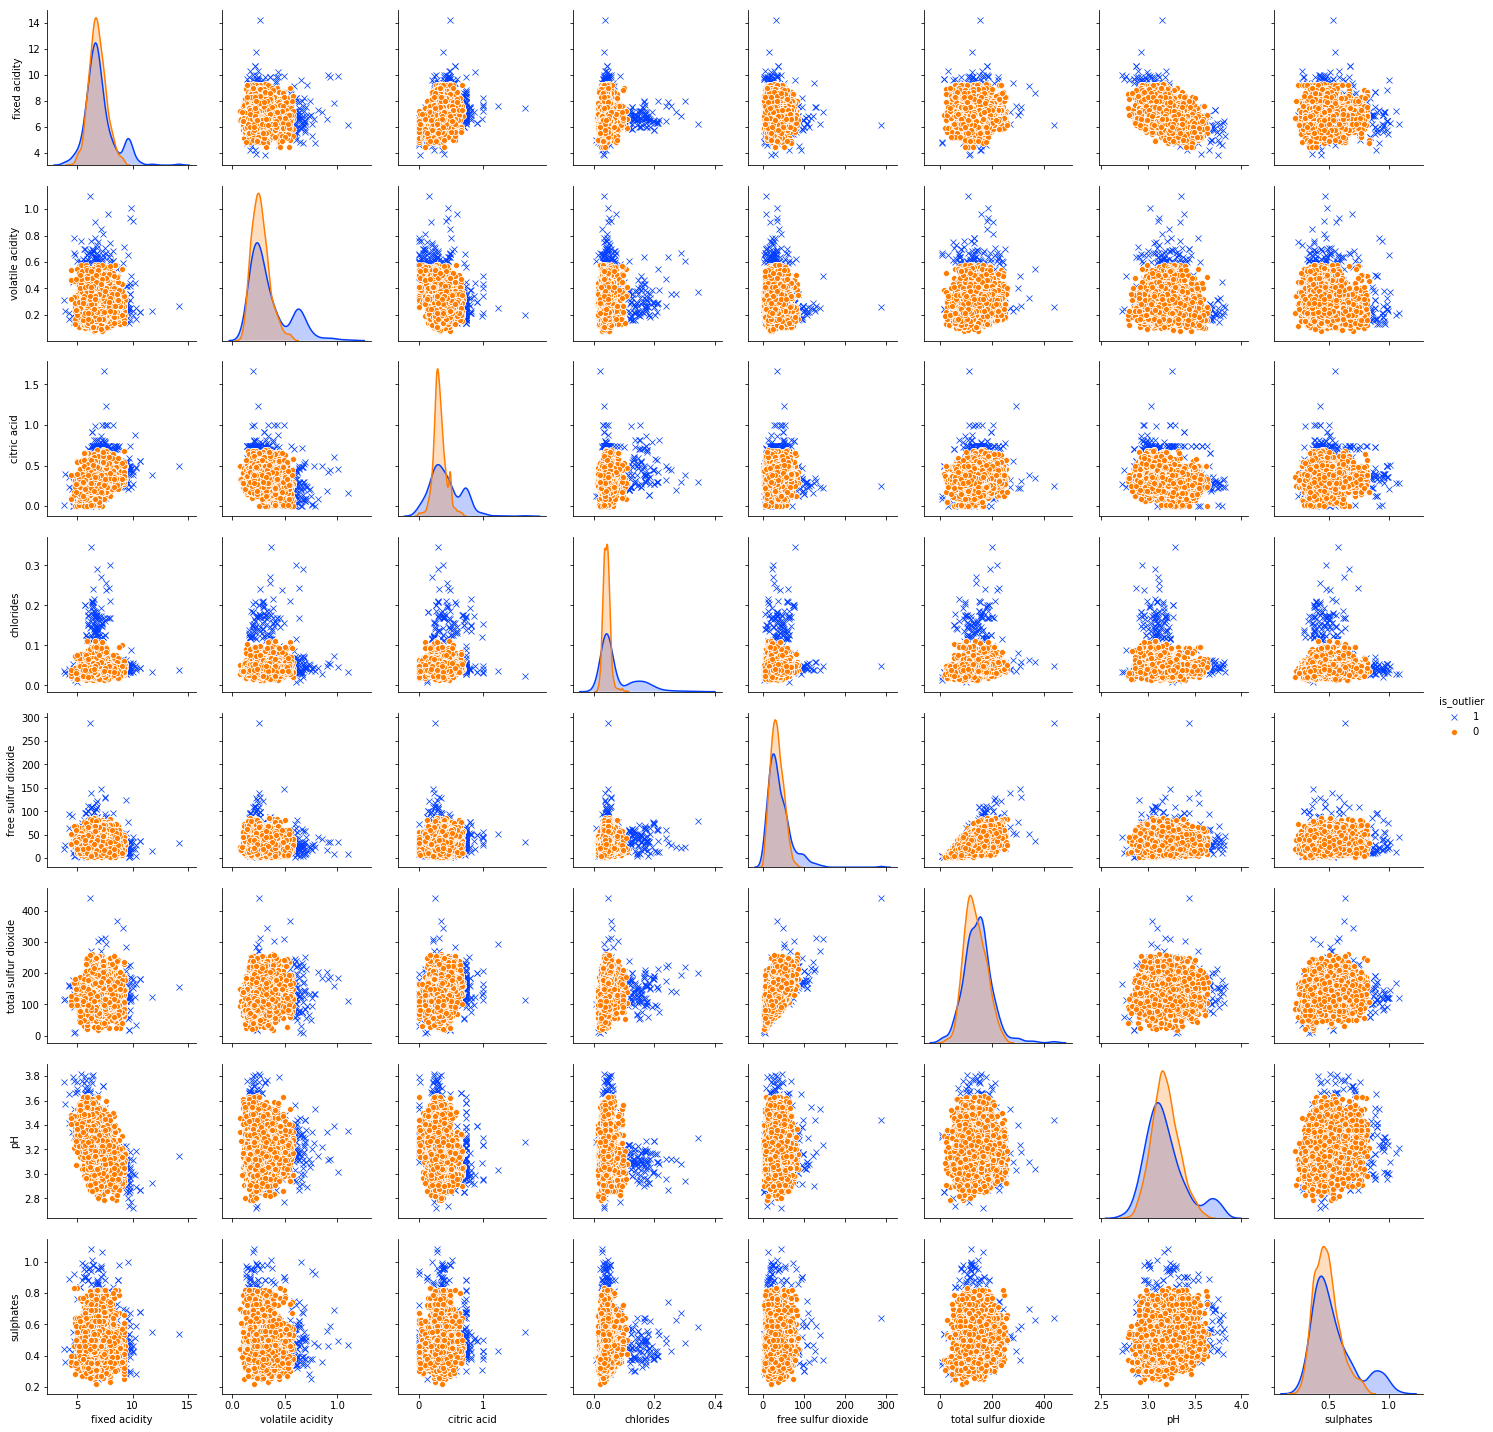

In [18]:
ax = sns.pairplot(data=labeled_data_frame, vars=normally_correlated_variables,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright')

## Отклонение от медианы на величину, большую 3-ёх межквартильных расстояний

In [19]:
def outlier_detect_IQR(data,col,threshold=3):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    return outlier_index, para

In [20]:
def multi_IQR_outlier(data, columns=[], threshold=3):
    if len(columns)==0:
        columns = data.columns.to_list()
    result = pd.DataFrame()
    outlier_indices = None
    outlier_fences = {k:[] for k in columns}
    outlier_list_index = []
    for col in columns:        
        index, fences = outlier_detect_IQR(data, col, threshold)
        if len(index.value_counts()) > 1:            
            outliers_absolute_count = index.value_counts()[1]
        else:
            outliers_absolute_count = 0
        outliers_relative_count = outliers_absolute_count / len(index)
        if outlier_indices is None:
            outlier_indices = data[index].index
        else:
            outlier_indices = outlier_indices.union(data[index].index)
        outlier_list_index.append(index)
        outlier_fences[col].append(fences[0])
        outlier_fences[col].append(fences[1])
        outlier_fences[col].append(outliers_absolute_count)
        outlier_fences[col].append(outliers_relative_count)
    fences_df = pd.DataFrame(data=outlier_fences, index=['upper_fence', 'lower_fence', 'outliers_total', 'outliers_relative'])
    return outlier_indices, fences_df, outlier_list_index

### Количество выбросов по параметрам

In [21]:
outlier_indices, outlier_info, outlier_index_list = multi_IQR_outlier(full_data_frame, numerical_parameters, threshold=3)
outlier_info.T.sort_values(by='outliers_total', ascending=False)

upper_fence  lower_fence  outliers_total  \
chlorides                0.092000     -0.00600           131.0   
volatile acidity         0.650000     -0.12000            39.0   
citric acid              0.750000     -0.09000            22.0   
sulphates                0.970000     -0.01000            11.0   
free sulfur dioxide    115.000000    -46.00000             8.0   
fixed acidity           10.300000      3.30000             4.0   
density                  1.009232      0.97859             3.0   
total sulfur dioxide   344.000000    -69.00000             2.0   
residual sugar          34.500000    -22.90000             1.0   
alcohol                 17.100000      3.80000             0.0   
pH                       3.850000      2.52000             0.0   

                      outliers_relative  
chlorides                      0.026746  
volatile acidity               0.007962  
citric acid                    0.004492  
sulphates                      0.002246  
free sulfur dioxide            0.001633  
fixed acidity                  0.000817  
density                        0.000612  
total sulfur dioxide           0.000408  
residual sugar                 0.000204  
alcohol                        0.000000  
pH                             0.000000

### Количество выбросов по набору данных

In [22]:
print("Общее количество примеров, содержащих выбросы: ", len(outlier_indices))
print("Общий по набору данных процент выбросов: ", len(outlier_indices) * 100. / len(full_data_frame))
print("Средний по параметрам процент выбросов: ", len(outlier_indices) * 100. / len(full_data_frame) / len(numerical_parameters))

Общее количество примеров, содержащих выбросы:  208
Общий по набору данных процент выбросов:  4.246631278072683
Средний по параметрам процент выбросов:  0.38605738891569846


In [23]:
iqr_outlier = np.zeros(len(full_data_frame))
for index in outlier_indices:
    iqr_outlier[index] = 1

In [24]:
labeled_data_frame = full_data_frame.copy(deep=True)
labeled_data_frame['is_outlier']=iqr_outlier

### Визуализация аномальных значений

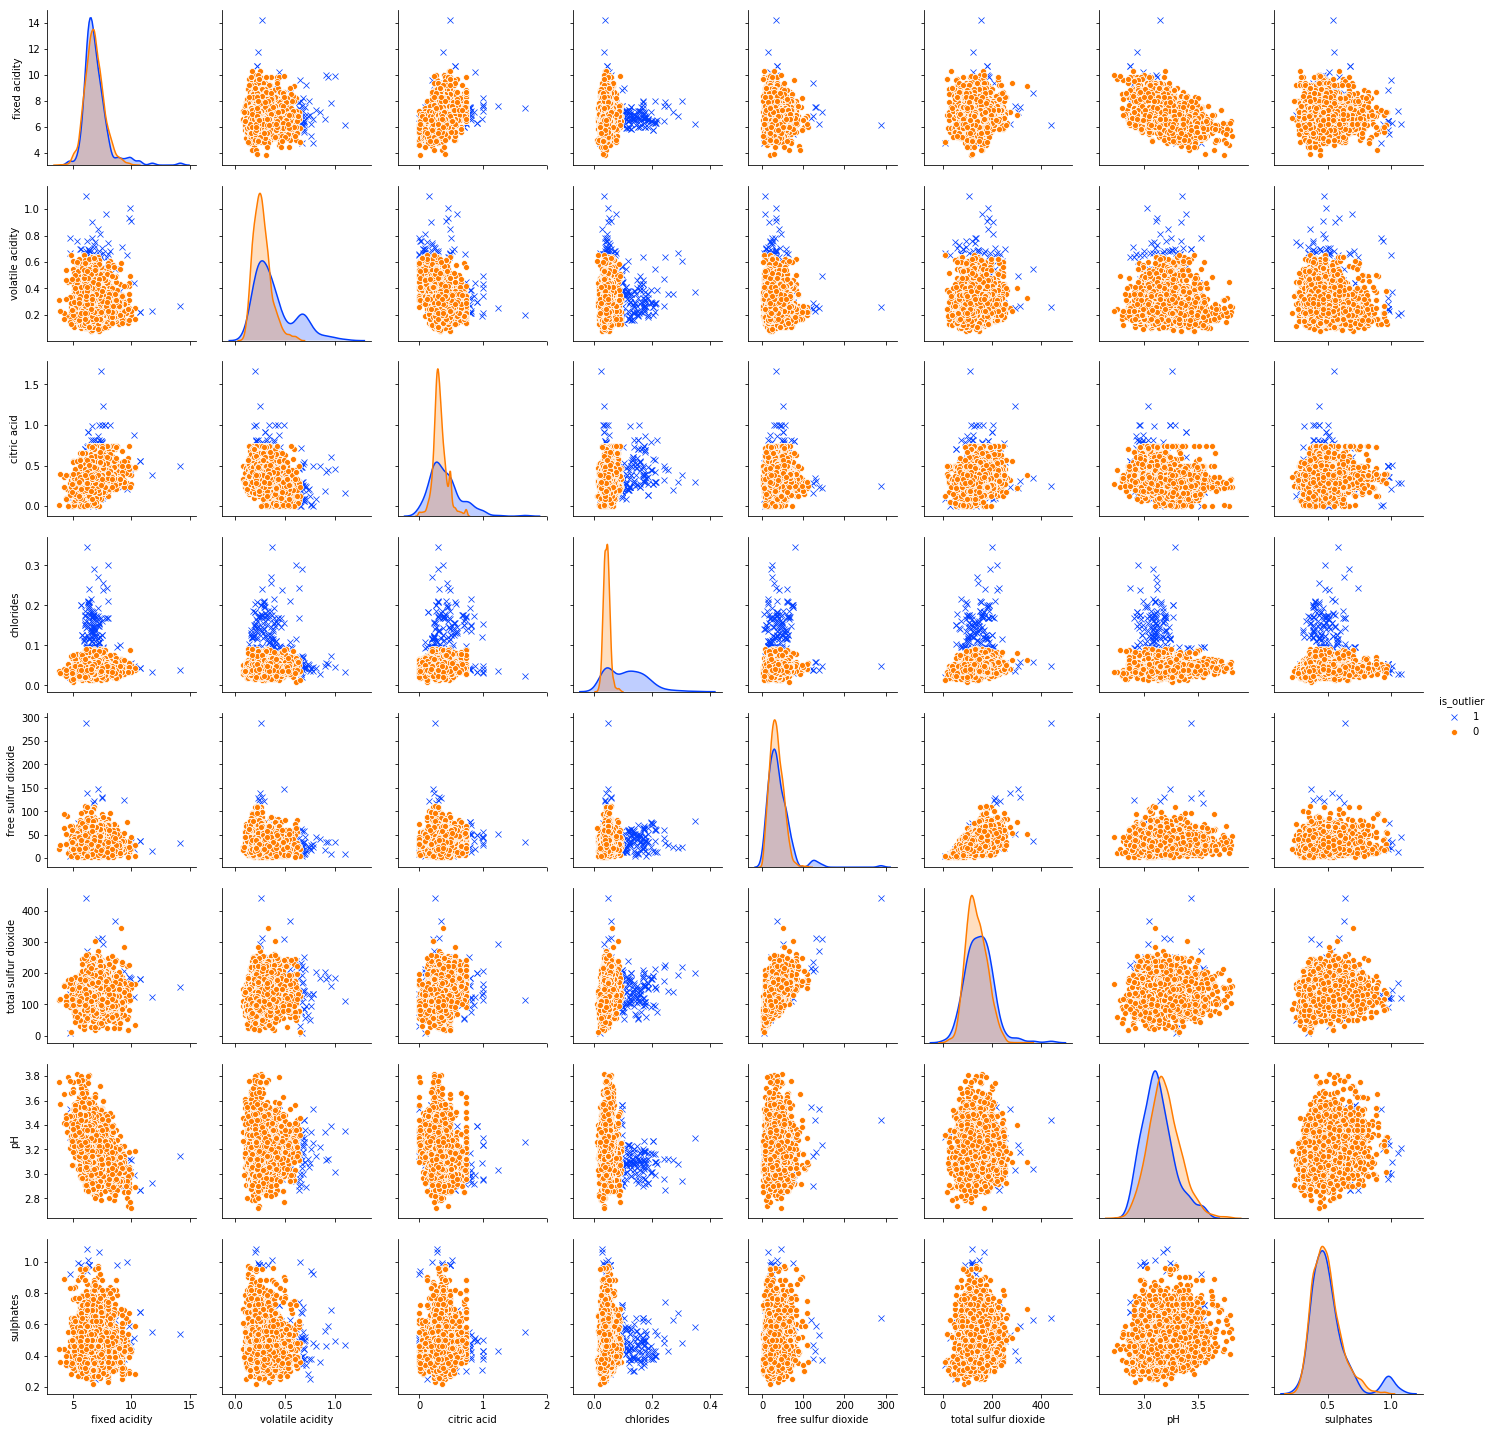

In [25]:
ax = sns.pairplot(data=labeled_data_frame, vars=normally_correlated_variables,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright')

### Больше всего "выбросов" - в параметре chlorides.

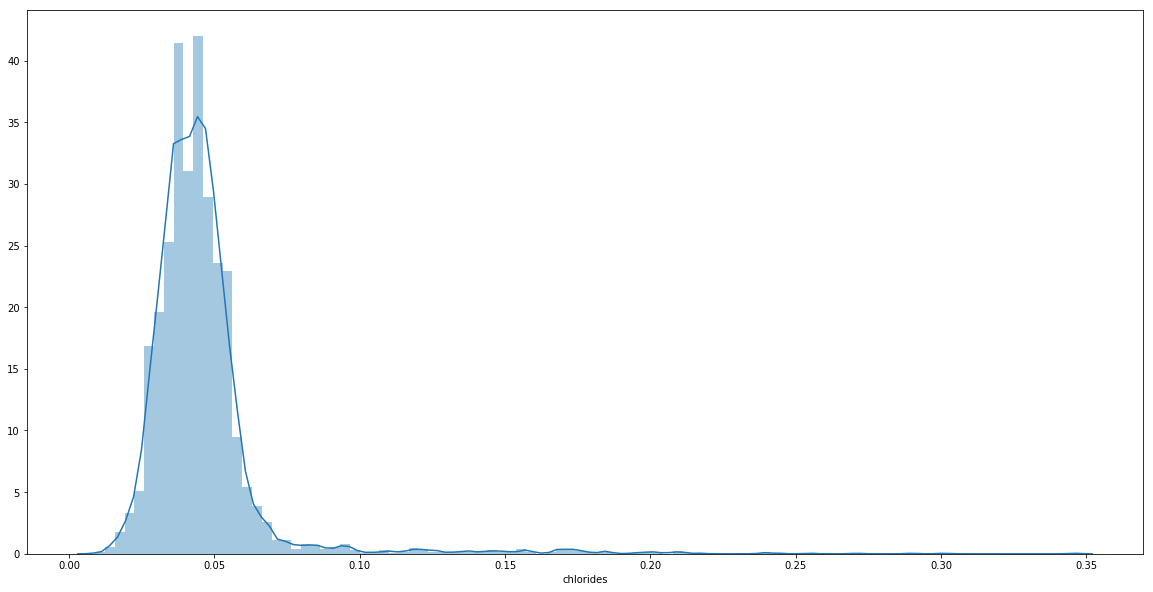

In [26]:
plt.figure(figsize=(20,10))
ax = sns.distplot(full_data_frame['chlorides'], bins=100)

### Заменим выбросы в этом параметре медианным значением

In [27]:
index, fences = outlier_detect_IQR(full_data_frame, 'chlorides', 3)
processed_data = full_data_frame.copy(deep=True)
processed_data.loc[index,'chlorides'] = processed_data['chlorides'].median()

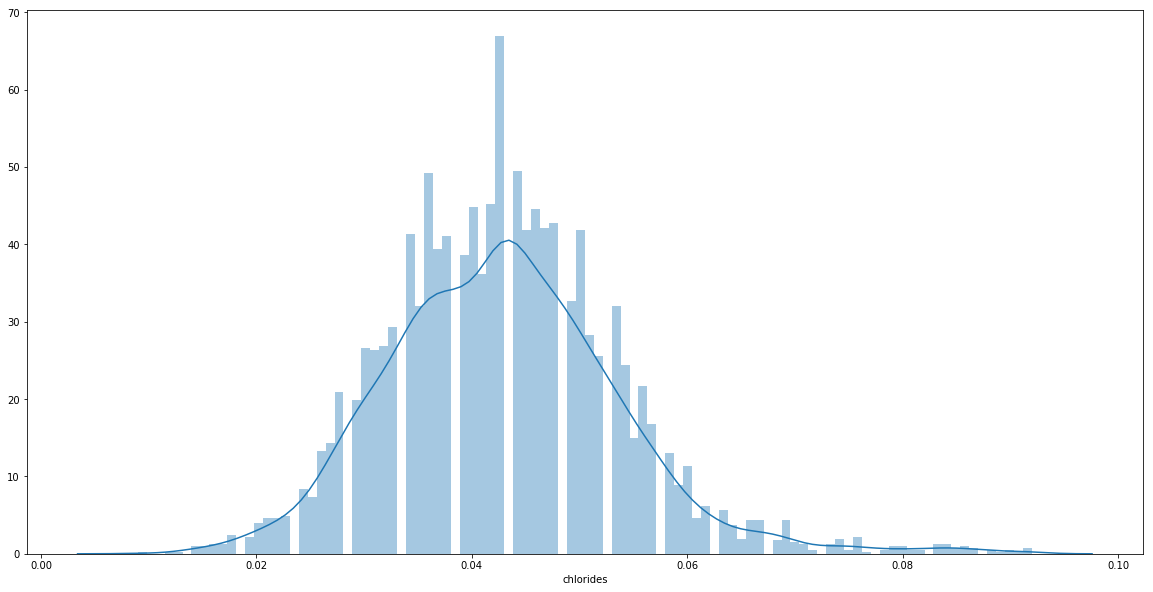

In [28]:
plt.figure(figsize=(20,10))
ax = sns.distplot(processed_data['chlorides'], bins=100)

## 3. Поиска анамалий на основе кластеризации

## Distance based

In [29]:
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist

In [30]:
from sklearn.preprocessing import RobustScaler

In [31]:
scaler = RobustScaler()
scaled_data = pd.DataFrame(data=scaler.fit_transform(processed_data), columns=processed_data.columns)
scaled_data = scaled_data.drop('quality', axis=1)

In [32]:
scaled_data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            0.2          0.090909     0.333333        1.890244   0.153846   
1           -0.5          0.363636     0.166667       -0.439024   0.461538   
2            1.3          0.181818     0.666667        0.207317   0.538462   
3            0.4         -0.272727     0.000000        0.402439   1.153846   
4            0.4         -0.272727     0.000000        0.402439   1.153846   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.478261              0.610169  1.658481 -0.947368  -0.142857   
1            -0.869565             -0.033898  0.059395  0.631579   0.142857   
2            -0.173913             -0.627119  0.310680  0.421053  -0.214286   
3             0.565217              0.881356  0.424900  0.052632  -0.500000   
4             0.565217              0.881356  0.424900  0.052632  -0.500000   

    alcohol  
0 -0.842105  
1 -0.473684  
2 -0.157895  
3 -0.263158  
4 -0.263158

In [33]:
class DistanceOutliers(BaseEstimator):
    """
    Distance based outlier detector model
    
    Fit method calculates centroid of training samples and
    using `metric` get distances from centroid to train samples.
    Having distances - we calculate `threshold` based on `percentile`.
    
    Predict method uses `threshold` and `metric` to determine, whether
    distance to sample from centroid is too large -> outlier.
    
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [34]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=90)
euclidian_model.fit(scaled_data)

In [35]:
distance_outlier = euclidian_model.predict(scaled_data)

In [36]:
labeled_data_frame = full_data_frame.copy(deep=True)
labeled_data_frame['is_outlier']=distance_outlier

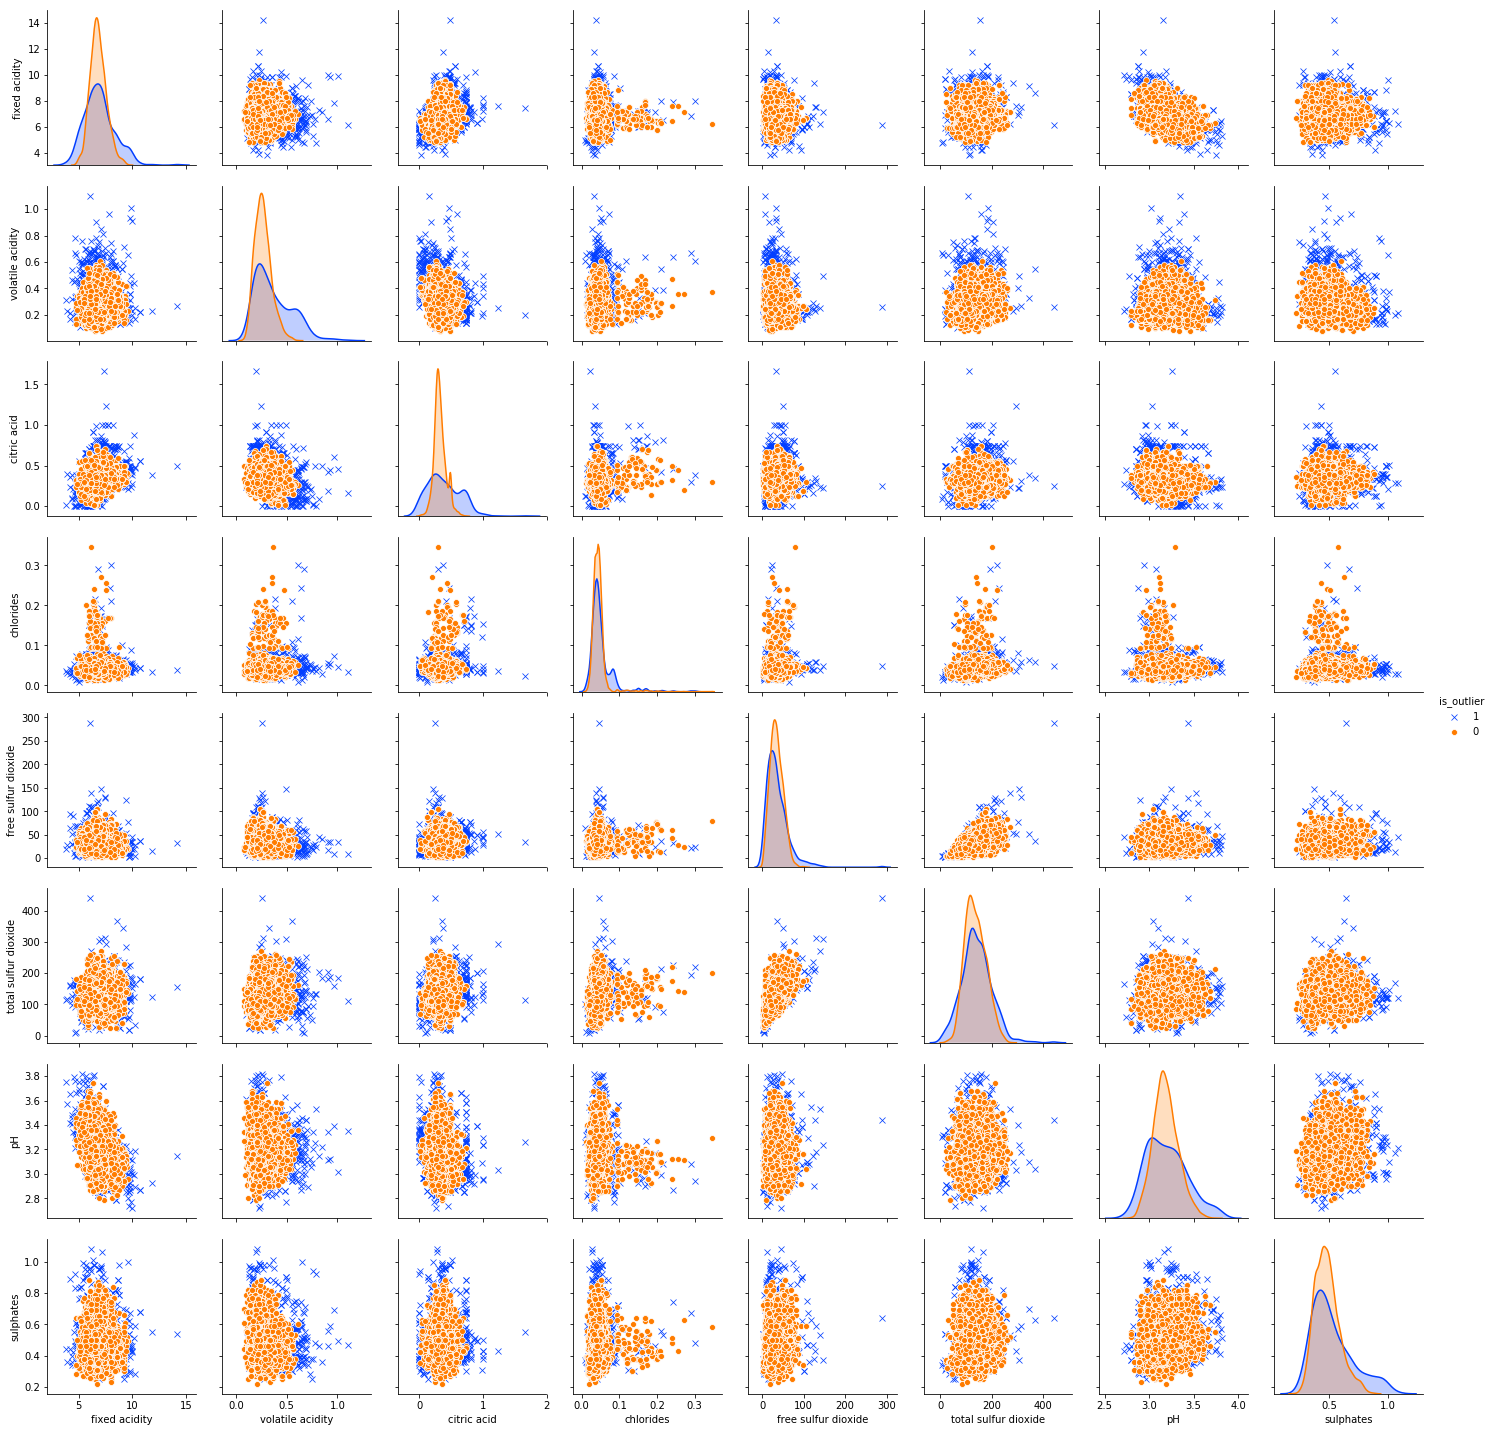

In [37]:
ax = sns.pairplot(data=labeled_data_frame, vars=normally_correlated_variables,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright')

In [39]:
pd.Series(distance_outlier).value_counts() / len(distance_outlier)

0    0.899959
1    0.100041
dtype: float64

## Density-based

In [40]:
from sklearn.cluster import DBSCAN

In [41]:
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []
eps = 0.05
while outlier_percentage>0.1:    
    model = DBSCAN(eps=eps).fit(scaled_data)
    labels = model.labels_
    labels = np.array([1 if label == -1 else 0 for label in labels])
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 0.05
    num_clusters.append(len(model.core_sample_indices_))
    anomaly_percentage.append(outlier_percentage)
    
model = DBSCAN(eps)
model.fit(scaled_data)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

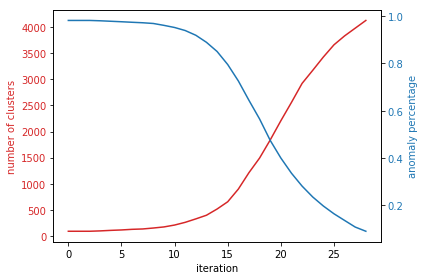

In [42]:
iterations = range(len(num_clusters))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iteration')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('anomaly percentage', color=color)  # we already handled the x-label with ax1
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [43]:
labeled_data_frame = scaled_data.copy(deep=True)
labeled_data_frame['is_outlier']=density_outlier

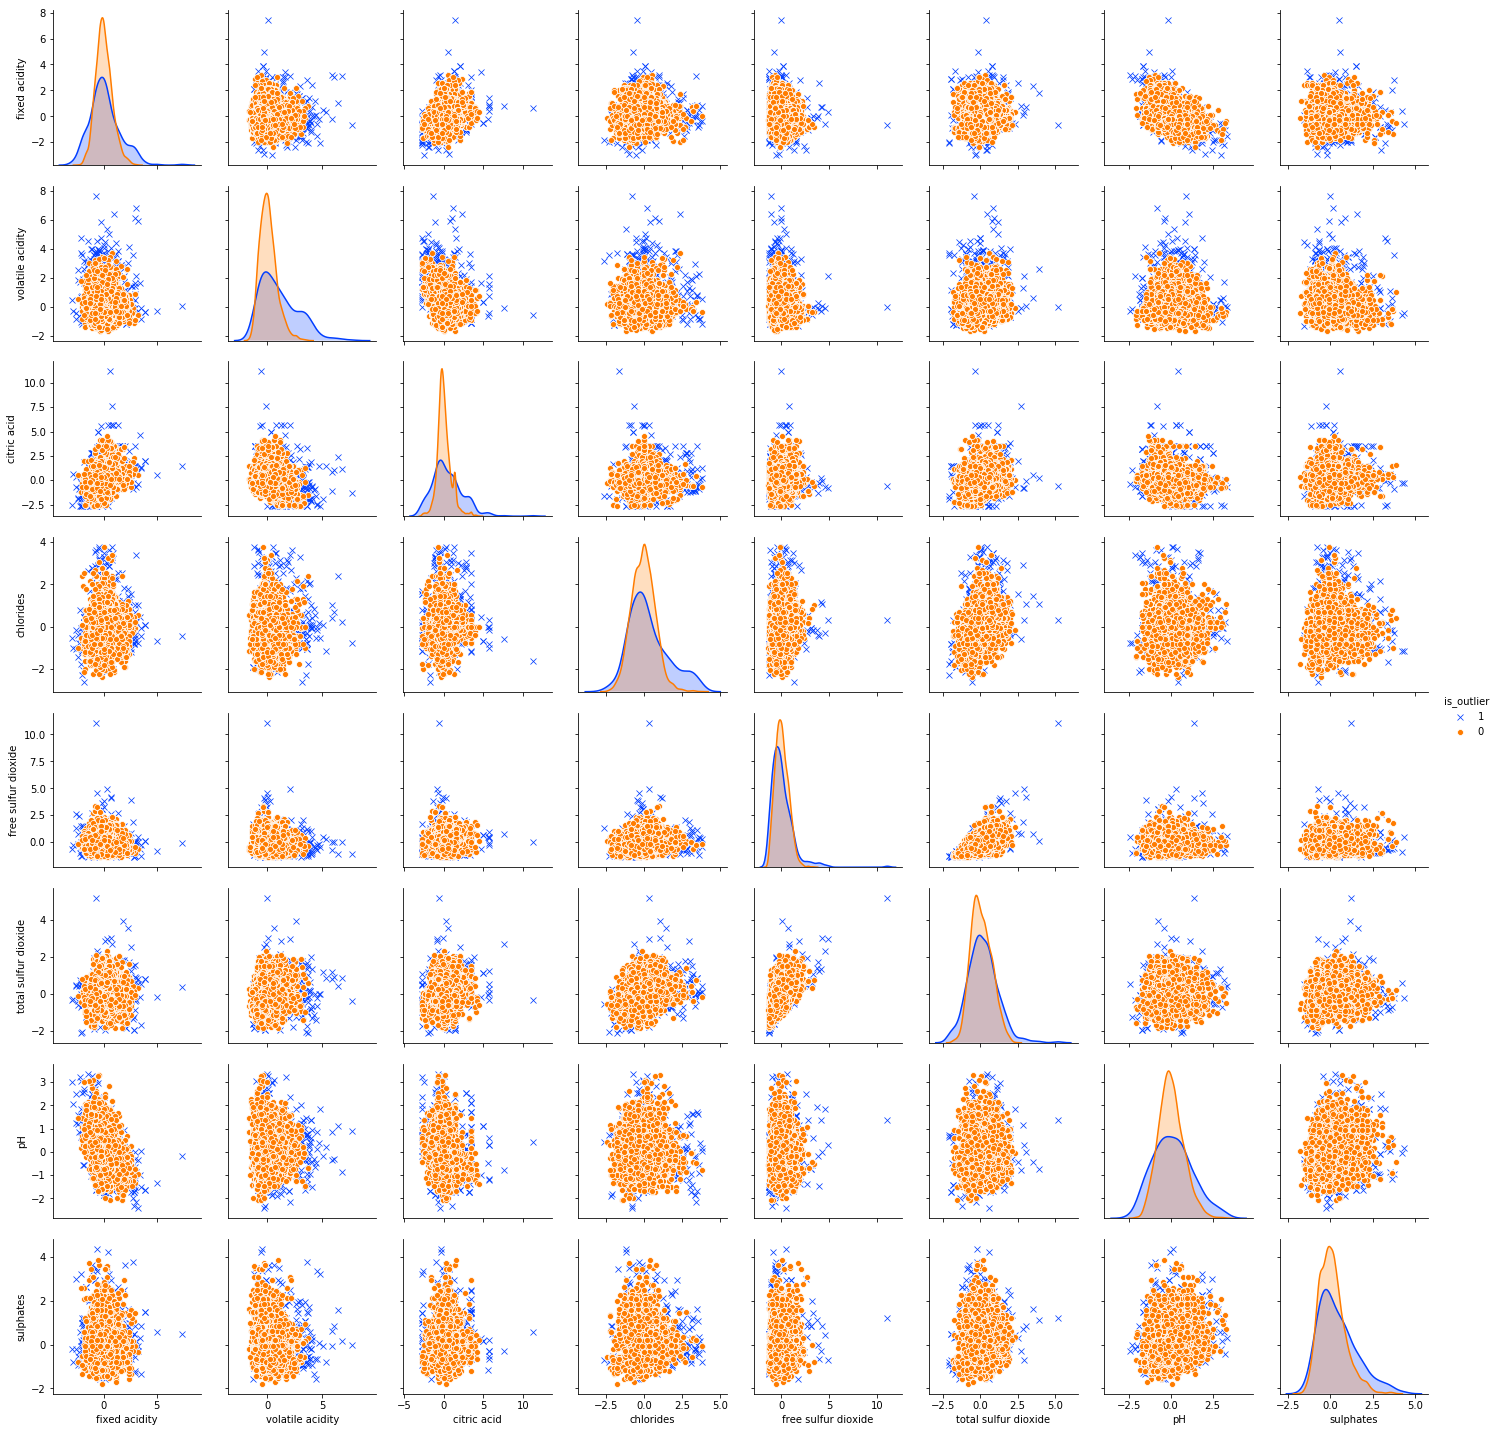

In [44]:
ax = sns.pairplot(data=labeled_data_frame, vars=normally_correlated_variables,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright')

## 4. Поиск анамалий с примененнием моделей 

## One-Class SVM

In [45]:
from sklearn.svm import OneClassSVM

In [46]:
clf = OneClassSVM(gamma='auto', nu=0.1).fit(scaled_data)
preds = clf.predict(scaled_data)
svm_outlier = np.array([1 if label == -1 else 0 for label in preds])

In [47]:
labeled_data_frame = scaled_data.copy(deep=True)
labeled_data_frame['is_outlier']=svm_outlier

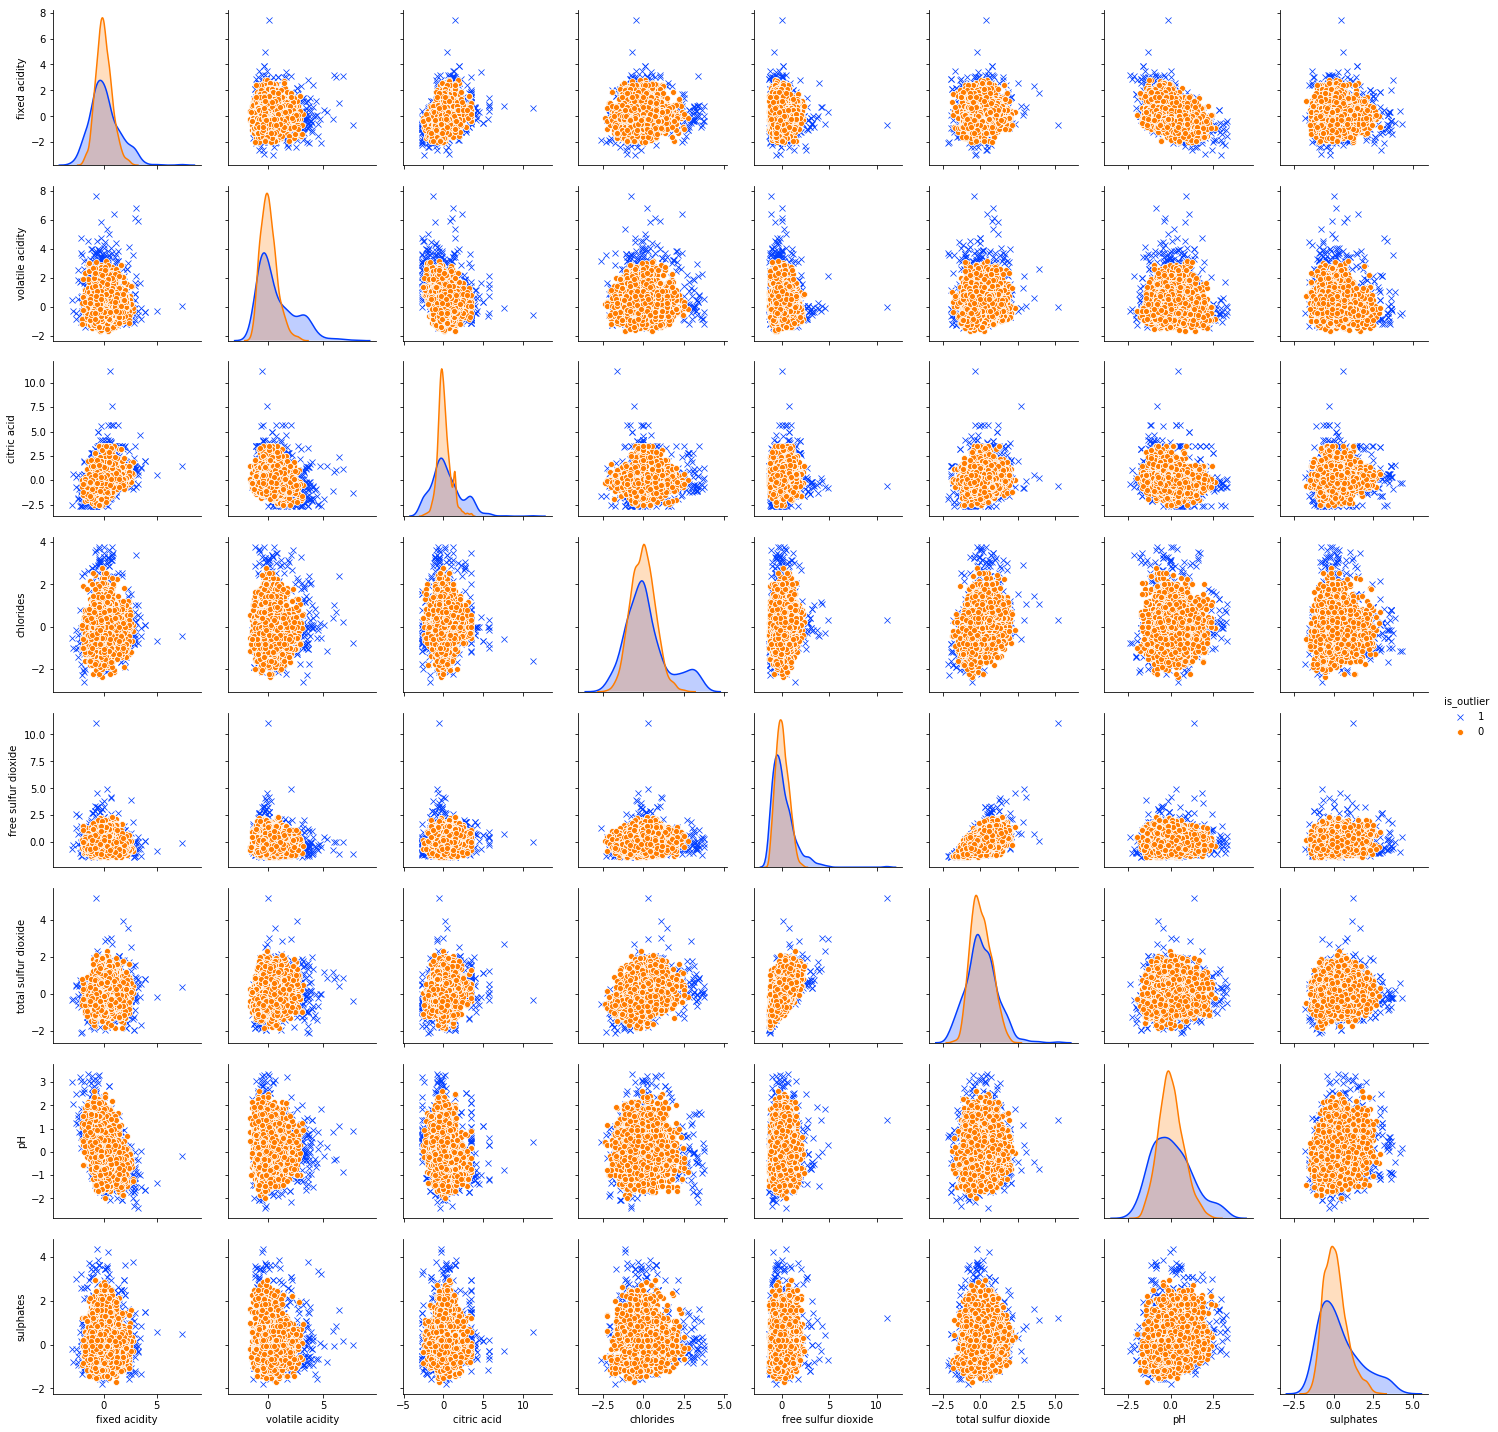

In [48]:
ax = sns.pairplot(data=labeled_data_frame, vars=normally_correlated_variables,
                  hue='is_outlier', hue_order=[1, 0],
                  markers=['x', 'o'],  palette='bright')

## Isolation forest

In [49]:
from sklearn.ensemble import IsolationForest

In [50]:
model = IsolationForest(behaviour='new', n_estimators=100, contamination=0.2, max_features=1.0, bootstrap=True)
model.fit(scaled_data)

IsolationForest(behaviour='new', bootstrap=True, contamination=0.2,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [51]:
preds = model.predict(scaled_data)
forest_outlier = np.array([1 if label == -1 else 0 for label in preds])

In [52]:
labeled_data_frame = scaled_data.copy(deep=True)
labeled_data_frame['is_outlier']=forest_outlier

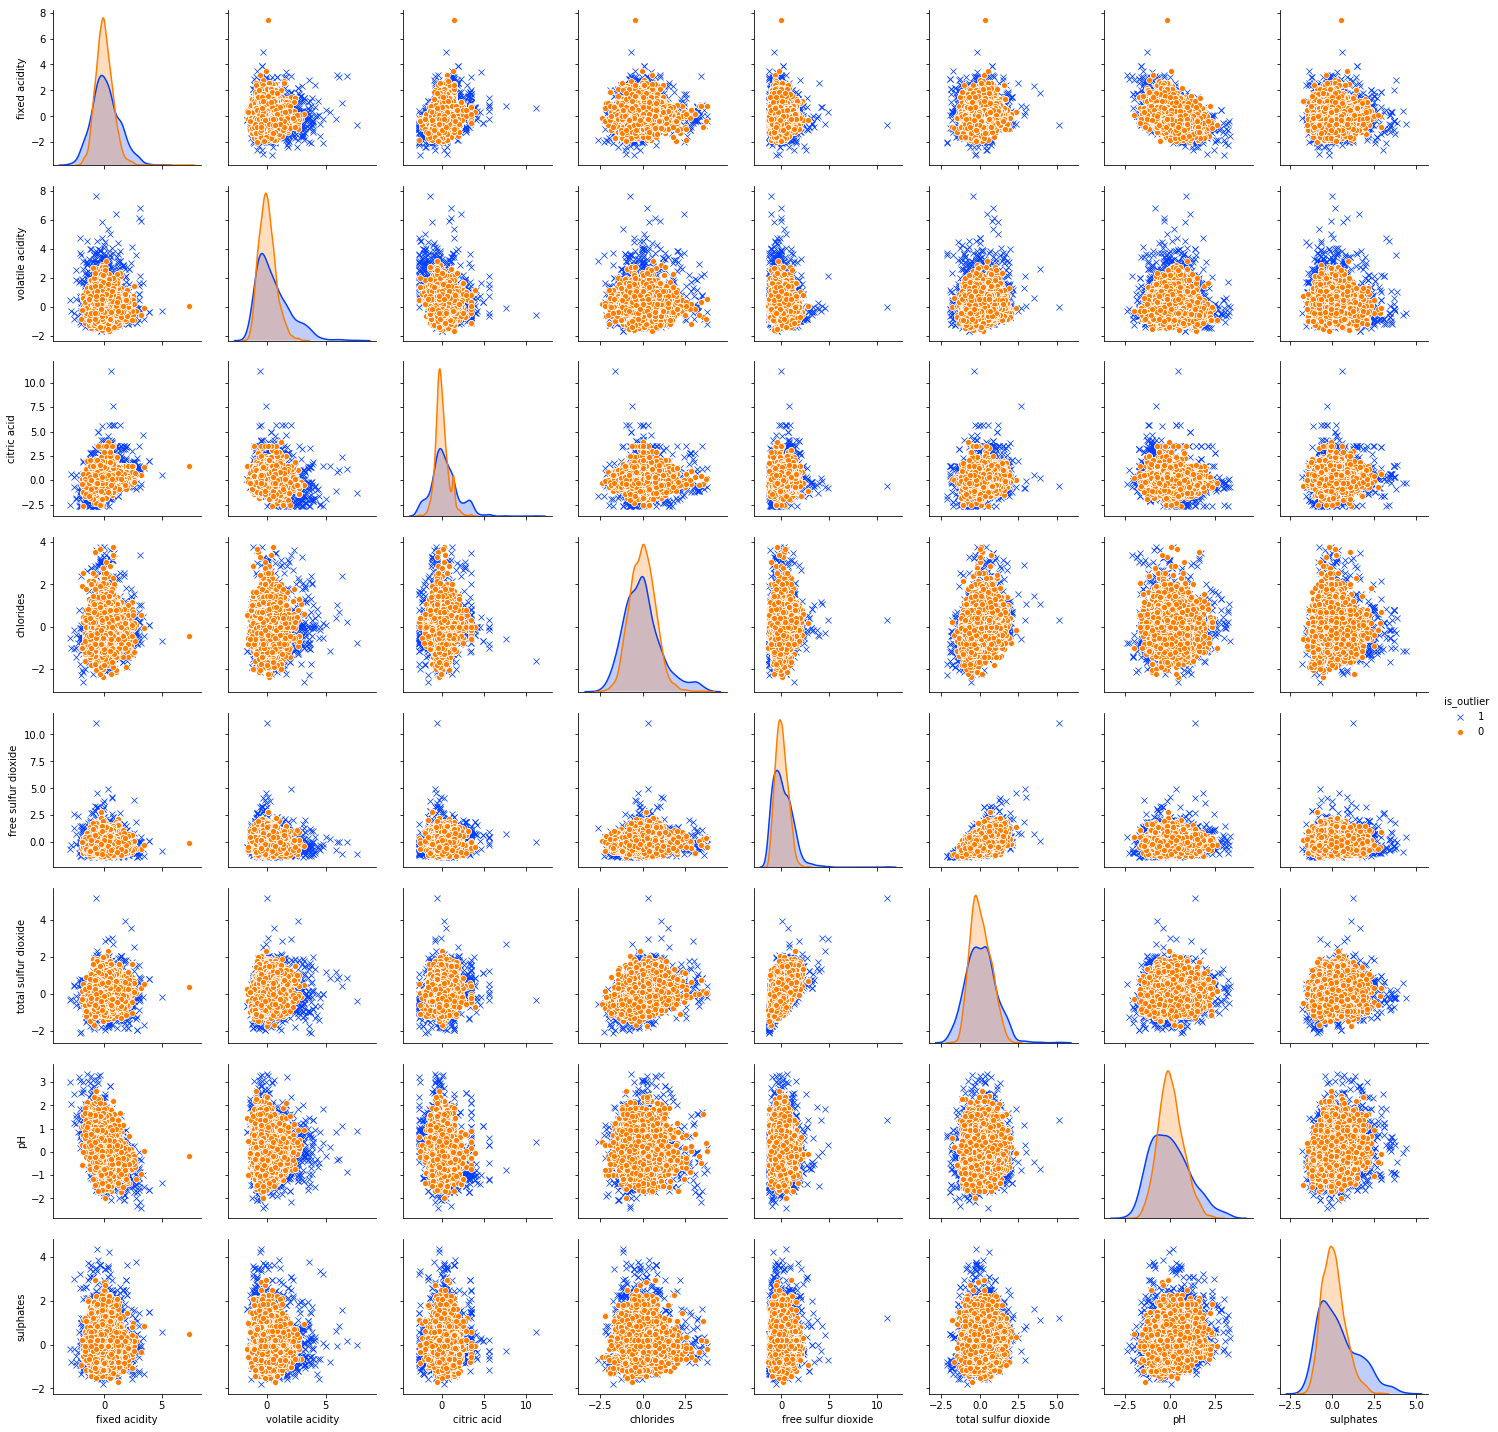

In [53]:
ax = sns.pairplot(data=labeled_data_frame, vars=normally_correlated_variables,
                  hue='is_outlier', hue_order=[1, 0],
                  markers=['x', 'o'],  palette='bright')

In [54]:
pd.Series(forest_outlier).value_counts()/len(forest_outlier)

0    0.799918
1    0.200082
dtype: float64

## 5. Сравнение результатов поиска аномалий

In [63]:
summary_array = np.concatenate(
    ([std_outlier], [iqr_outlier],
     [distance_outlier], [density_outlier],
     [svm_outlier], [forest_outlier])
)

### Бинарные оценки аномалий сведём в общую таблицу

In [67]:
summary_outliers= pd.DataFrame(data=summary_array.T, columns = ['std', 'iqr', 'distance', 'density', 'svm', 'forest'])

In [69]:
summary_outliers.head(10)

std  iqr  distance  density  svm  forest
0  0.0  0.0       0.0      0.0  0.0     0.0
1  0.0  0.0       0.0      0.0  0.0     0.0
2  0.0  0.0       0.0      0.0  0.0     0.0
3  0.0  0.0       0.0      0.0  0.0     0.0
4  0.0  0.0       0.0      0.0  0.0     0.0
5  0.0  0.0       0.0      0.0  0.0     0.0
6  0.0  0.0       0.0      0.0  0.0     0.0
7  0.0  0.0       0.0      0.0  0.0     0.0
8  0.0  0.0       0.0      0.0  0.0     0.0
9  0.0  0.0       0.0      0.0  0.0     0.0

### Условный "рейтинг" аномалий рассчитаем как сумму оценок всех методов и моделей

In [77]:
outlier_score = summary_outliers.sum(axis=1)

In [78]:
outlier_score.value_counts()

0.0    3738
1.0     454
2.0     234
3.0     143
4.0     134
5.0     124
6.0      71
dtype: int64

### Упростим рейтинг:
### - если за пример "проголосовали" меньше трёх моделей, считаем пример уверенно "нормальным" с рейтингом 0,
### - если 3 модели определили пример, как аномалию, рейтинг 0,5 - неуверенно аномальный,
### - если "проголосовали" более 3-ёх моделей, рейтинг 1 - уверенно анамальный.

In [96]:
simple_score = outlier_score.apply(lambda x: 0 if x < 3 else 0.5 if x==3 else 1)

In [97]:
simple_score.value_counts()

0.0    4426
1.0     329
0.5     143
dtype: int64

### Визуализруем рассчитанный рейтинг.
### <font color=green>Зелёный цвет - "нормальные" данные</font>, <font color=red>красный - аномалии</font>, <font color=blue>синий - не определено</font>

In [101]:
labeled_data_frame = scaled_data.copy(deep=True)
labeled_data_frame['is_outlier']=simple_score

In [104]:
custom_palette = {0:'g', 0.5:'b', 1.0:'r'}

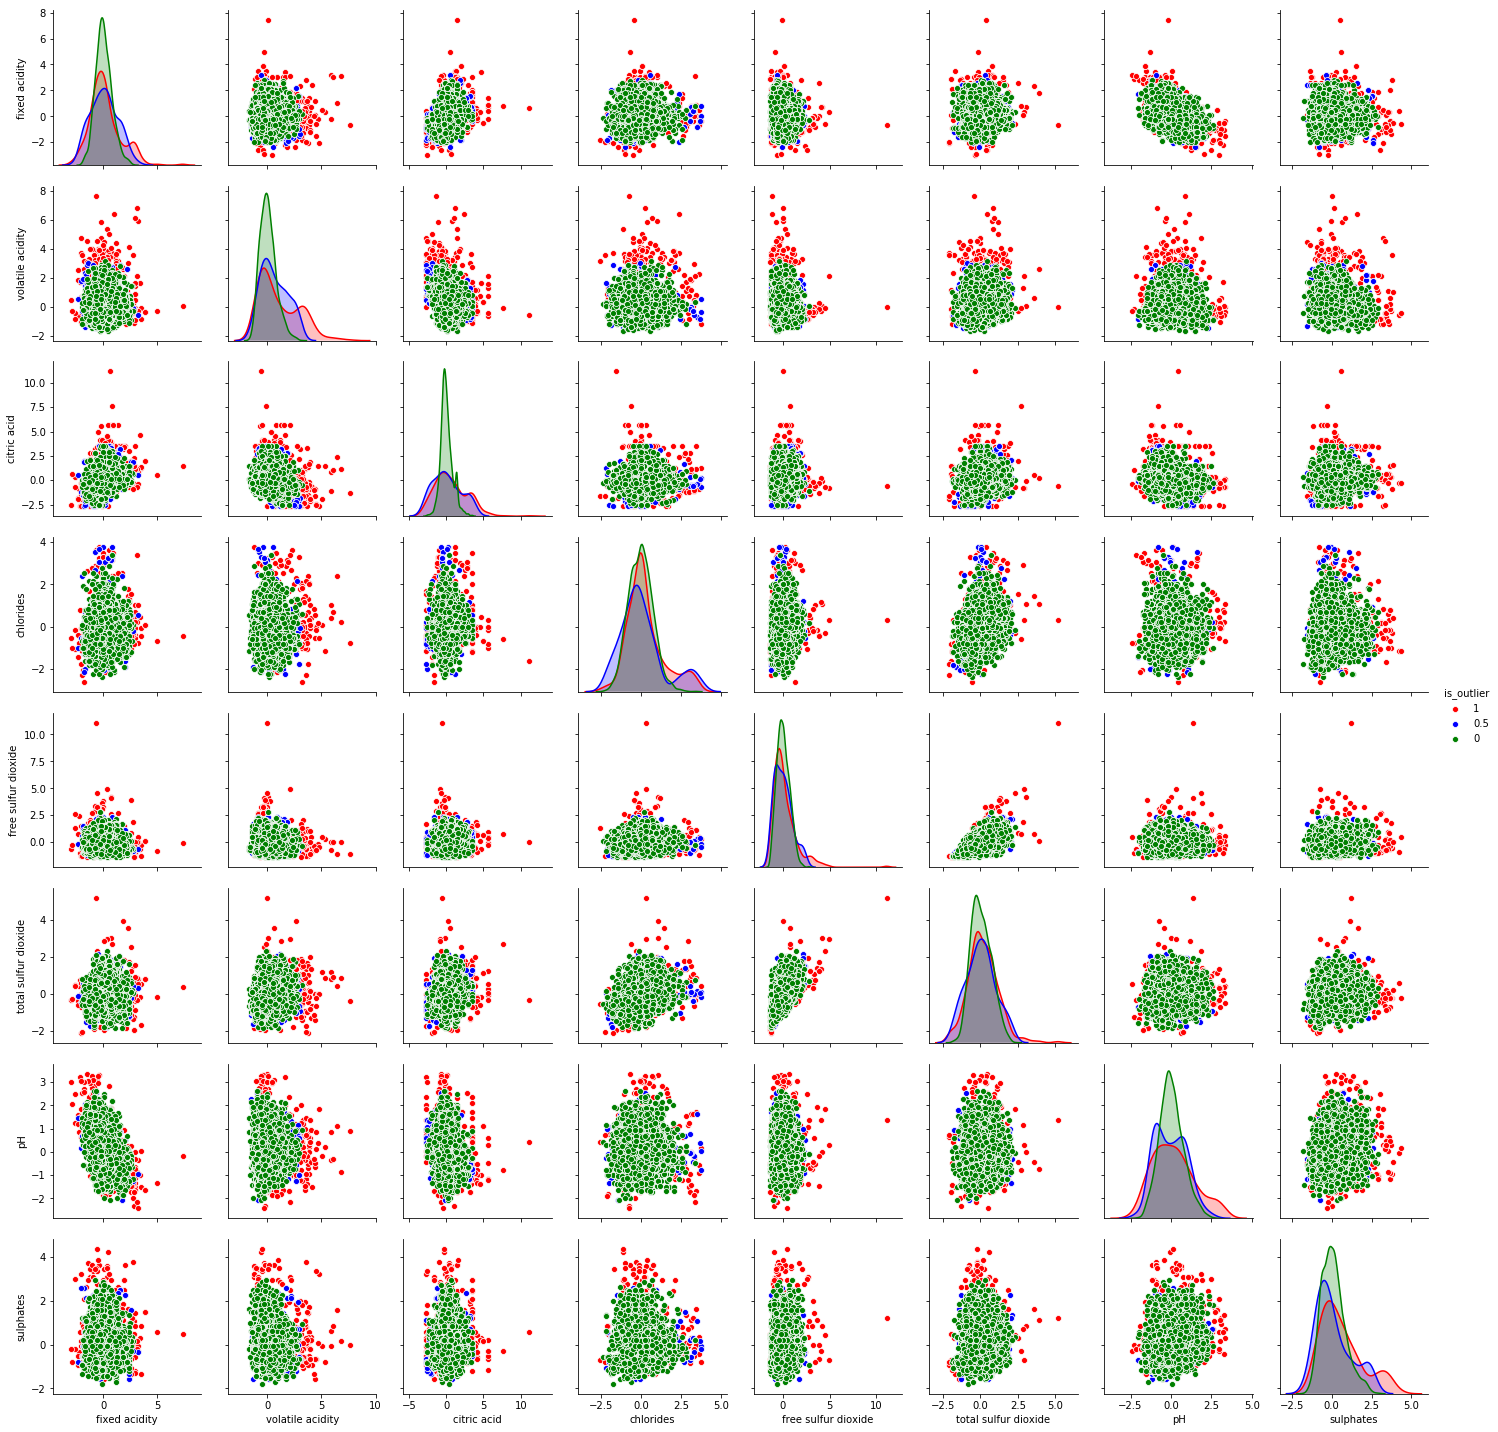

In [105]:
ax = sns.pairplot(data=labeled_data_frame, vars=normally_correlated_variables, hue='is_outlier',
                  hue_order=[1, 0.5, 0],
                  palette=custom_palette)

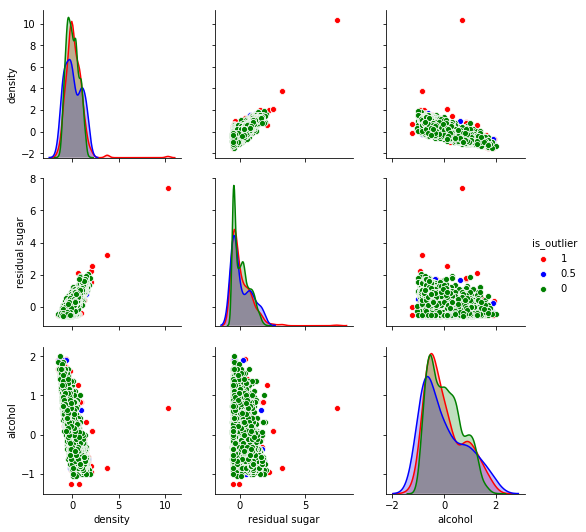

In [108]:
ax = sns.pairplot(data=labeled_data_frame, vars=abnormally_correlated_variables, hue='is_outlier',
                  hue_order=[1, 0.5, 0],
                  palette=custom_palette)